# We start off by importing the data

In [133]:
import pandas as pd
df = pd.read_csv('data/vac.csv', sep=',', index_col=0, parse_dates=True) # it's important to define index and parse_dates



## We'll have a look at the column names

In [134]:
# list(df.columns.values)

### Let's remove columns that don't interest us

In [135]:
uninteresting = ['indikation_alter_dosen', 'indikation_alter_erst', 'indikation_alter_voll',
                 'indikation_beruf_dosen', 'indikation_beruf_erst', 'indikation_beruf_voll',
                 'indikation_medizinisch_dosen', 'indikation_medizinisch_erst', 'indikation_medizinisch_voll',
                'indikation_pflegeheim_dosen', 'indikation_pflegeheim_erst', 'indikation_pflegeheim_voll']

different_vaccines = ['dosen_biontech_kumulativ', 'dosen_erst_biontech_kumulativ', 'dosen_voll_biontech_kumulativ',
                      'dosen_moderna_kumulativ', 'dosen_erst_moderna_kumulativ', 'dosen_voll_moderna_kumulativ',
                      'dosen_astrazeneca_kumulativ', 'dosen_erst_astrazeneca_kumulativ', 'dosen_voll_astrazeneca_kumulativ']

df = df.drop(uninteresting, axis=1)
df = df.drop(different_vaccines, axis=1)
list(df.columns.values)


['publication_date',
 'dosen_kumulativ',
 'personen_erst_kumulativ',
 'personen_voll_kumulativ',
 'dosen_differenz_zum_vortag',
 'dosen_erst_differenz_zum_vortag',
 'dosen_voll_differenz_zum_vortag',
 'impf_quote_dosen',
 'impf_quote_erst',
 'impf_quote_voll',
 'impf_inzidenz_dosen',
 'impf_inzidenz_erst',
 'impf_inzidenz_voll']

### Or actually let's just pick the few columns that interest us

In [136]:
df = df[['publication_date', 'dosen_kumulativ', 'impf_inzidenz_dosen']]

# Let's fix the data

### We'll first fill missing rows, Saturdays seem to be missing!

In [137]:
df.head()

,publication_date,dosen_kumulativ,impf_inzidenz_dosen
date,,,
2020-12-27,2020-12-28 16:15,3389,0.258215
2020-12-28,2020-12-29 08:00,5219,0.397646
2020-12-30,2020-12-31 08:30,28206,2.149072
2020-12-31,2021-01-01 12:30,37955,2.891867
2021-01-01,2021-01-02 08:00,39005,2.971869


In [138]:
idx = pd.date_range(df.index.min(), df.index.max())

df = df.reindex(idx, method='ffill')

# Create new index column because that's waay easier than having the date column be the index
df = df.reset_index()
df = df.rename(columns={'index': 'date'})
#fill_value=0 
# convert column "a" to int64 dtype and "b" to complex type
# df = df.astype({'dosen_kumulativ': int})

In [139]:
# df['dosen_kumulativ'] = df['dosen_kumulativ'].fillna(method='ffill')
# df['impf_inzidenz_dosen'] = df['impf_inzidenz_dosen'].fillna(0)
# df.head(5)

### Let's fix errors in the data. There are two spikes, that just seem out of place

In [140]:
df.dosen_kumulativ = df.dosen_kumulativ.replace(384311, 343668)
df.dosen_kumulativ = df.dosen_kumulativ.replace(1150129, 1186228)
# df.dosen_kumulativ.replace(343668, 384311)

# df.at[29, 'dosen_kumulativ'] = 343668
# df.at['2020-03-03', 'dosen_kumulativ'] = 1186228




# Let's add some new useful columns

## New column: Day of the week


In [141]:
df.date


0    2020-12-27
1    2020-12-28
2    2020-12-29
3    2020-12-30
4    2020-12-31
        ...    
85   2021-03-22
86   2021-03-23
87   2021-03-24
88   2021-03-25
89   2021-03-26
Name: date, Length: 90, dtype: datetime64[ns]

In [142]:
def week_day_string(weekday):
    if weekday == 0:
        return 'Mon'
    elif weekday == 1:
        return 'Tue'
    elif weekday == 2:
        return 'Wed'
    elif weekday == 3:
        return 'Thu'
    elif weekday == 4:
        return 'Fri'
    elif weekday == 5:
        return 'Sat'
    elif weekday == 6:
        return 'Sun'
    else:
        return 'other'

def is_weekend(weekday):
    if weekday == 5:
        return True
    elif weekday == 6:
        return True
    else:
        return False

df['weekday'] = df.date.dt.dayofweek
df['is_weekend'] = df.apply(lambda x: is_weekend(x['weekday']), axis=1)
df['weekday_name'] = df.apply(lambda x: week_day_string(x['weekday']), axis=1)
df['calendar_week'] = df.date.dt.week

<ipython-input-142-87754649e6d3>:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['calendar_week'] = df.date.dt.week


In [143]:
df.tail(25)

,date,publication_date,dosen_kumulativ,impf_inzidenz_dosen,weekday,is_weekend,weekday_name,calendar_week
65,2021-03-02,2021-03-03 10:00,1145669,87.290816,1,False,Tue,9
66,2021-03-03,2021-03-04 08:00,1186228,87.630632,2,False,Wed,9
67,2021-03-04,2021-03-05 08:00,1226788,93.471435,3,False,Thu,9
68,2021-03-05,2021-03-06 08:00,1269507,96.726281,4,False,Fri,9
69,2021-03-06,2021-03-06 08:00,1269507,96.726281,5,True,Sat,9
70,2021-03-07,2021-03-08 08:00,1332835,101.551368,6,True,Sun,9
71,2021-03-08,2021-03-09 08:00,1370922,104.453293,0,False,Mon,10
72,2021-03-09,2021-03-10 08:00,1410941,107.502421,1,False,Tue,10
73,2021-03-10,2021-03-11 08:00,1454715,110.837650,2,False,Wed,10
74,2021-03-11,2021-03-12 08:00,1501539,114.405264,3,False,Thu,10


### Let's fix the sunday value describing the whole weekend


In [144]:
to_modify = []
prev_value = -1

for index, row in df.iterrows():
    if row['dosen_kumulativ'] == prev_value and row['weekday'] == 5 :
        to_modify.append(index)
    prev_value = row['dosen_kumulativ']

print(f'Saturdays with 0 {to_modify}')

for i in to_modify:
    try:
        sunday_value = df.loc[df.index == i+1, 'dosen_kumulativ'].values[0]
        dif = sunday_value - df.loc[df.index == i, 'dosen_kumulativ'].values[0]
        add = int(dif / 2)
        new_total = df.loc[df.index == i, 'dosen_kumulativ'].values[0] + add
        df.loc[df.index == i, 'dosen_kumulativ'] = new_total
        print(f'modifying dosen_kumu of {i} to {new_total} using {sunday_value} and half diff which is {add}')
    except IndexError:
        print("An exception occurred")


Saturdays with 0 [13, 20, 27, 34, 41, 48, 55, 62, 69, 76, 83]
modifying dosen_kumu of 13 to 107051 using 120136 and half diff which is 13085
modifying dosen_kumu of 20 to 206222 using 213837 and half diff which is 7615
modifying dosen_kumu of 27 to 306601 using 322334 and half diff which is 15732
modifying dosen_kumu of 34 to 425052 using 440401 and half diff which is 15349
modifying dosen_kumu of 41 to 567022 using 581268 and half diff which is 14246
modifying dosen_kumu of 48 to 693360 using 708757 and half diff which is 15396
modifying dosen_kumu of 55 to 852059 using 872076 and half diff which is 20017
modifying dosen_kumu of 62 to 1052922 using 1078189 and half diff which is 25266
modifying dosen_kumu of 69 to 1301171 using 1332835 and half diff which is 31664
modifying dosen_kumu of 76 to 1585113 using 1621834 and half diff which is 36720
modifying dosen_kumu of 83 to 1815078 using 1843439 and half diff which is 28361


## New column Differenz in total doses

In [145]:
df['vortag_dosen_dif'] = df.dosen_kumulativ - df.dosen_kumulativ.shift(1)
df['vortag_dosen_dif'] = df['vortag_dosen_dif'].fillna(0)
df = df.astype({'vortag_dosen_dif': 'int64'})



## Let's take a look

In [146]:
df.tail(14)

,date,publication_date,dosen_kumulativ,impf_inzidenz_dosen,weekday,is_weekend,weekday_name,calendar_week,vortag_dosen_dif
76,2021-03-13,2021-03-13 08:00,1585113,117.975164,5,True,Sat,10,36720
77,2021-03-14,2021-03-15 08:00,1621834,123.570781,6,True,Sun,10,36721
78,2021-03-15,2021-03-16 08:00,1663320,126.731682,0,False,Mon,11,41486
79,2021-03-16,2021-03-17 08:00,1693303,129.016147,1,False,Tue,11,29983
80,2021-03-17,2021-03-18 08:00,1724990,131.430443,2,False,Wed,11,31687
81,2021-03-18,2021-03-19 08:00,1756506,133.831710,3,False,Thu,11,31516
82,2021-03-19,2021-03-20 08:00,1786717,136.133547,4,False,Fri,11,30211
83,2021-03-20,2021-03-20 08:00,1815078,136.133547,5,True,Sat,11,28361
84,2021-03-21,2021-03-22 08:00,1843439,140.455310,6,True,Sun,11,28361
85,2021-03-22,2021-03-23 08:00,1880678,143.292624,0,False,Mon,12,37239


In [147]:
current_official_doses = df.tail(1)['dosen_kumulativ']
#current_official_doses.values[0]
current_official_doses

89    2071325
Name: dosen_kumulativ, dtype: int64

<AxesSubplot:title={'center':'Impfungen Bayern'}, xlabel='date'>

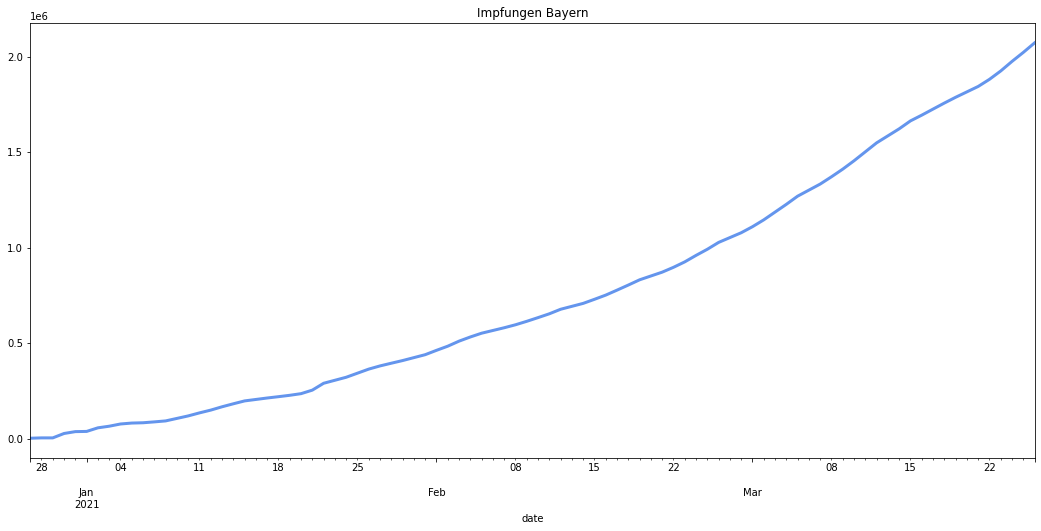

In [148]:
df.set_index('date')['dosen_kumulativ'].plot.line(figsize=(18,8), color='cornflowerblue', linewidth=3, title='Impfungen Bayern')


In [149]:
print(df['vortag_dosen_dif'].max())
print(df['vortag_dosen_dif'].min())


50013
0


In [150]:
int(df.tail(3)['vortag_dosen_dif'].values.mean())

48941

<AxesSubplot:title={'center':'Rolling Impfdosen differenz zum Vortag - Bayern'}, xlabel='date'>

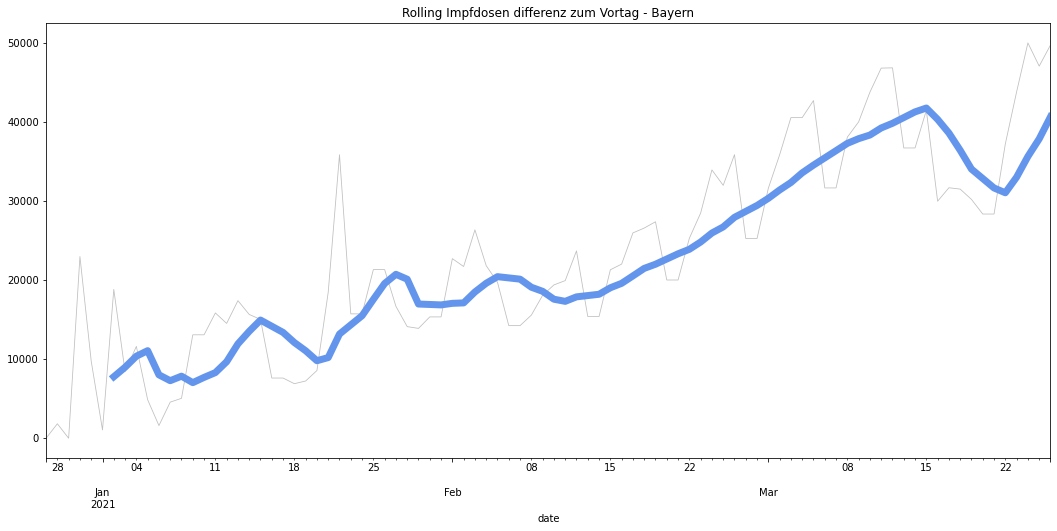

In [151]:
df['rolling_vortag_dosen_dif'] = df.vortag_dosen_dif.rolling(7).mean()
df.set_index('date')['vortag_dosen_dif'].plot.line(x='date', figsize=(18,8), color='silver', linewidth=0.8)
df.set_index('date')['rolling_vortag_dosen_dif'].plot.line(x='date', figsize=(18,8), color='cornflowerblue', linewidth=7, title='Rolling Impfdosen differenz zum Vortag - Bayern')


## Vaccinations per weekday

In [152]:
def avg_vacs_per_weekday_last_x_weeks(x):
    df.tail(7*x).groupby(["weekday_name"])['vortag_dosen_dif'].mean().sort_values().plot.bar(x='weekday_name', figsize=(10,6), color='seagreen', title=f'Average vaccinations per weekday (last {x} weeks)')


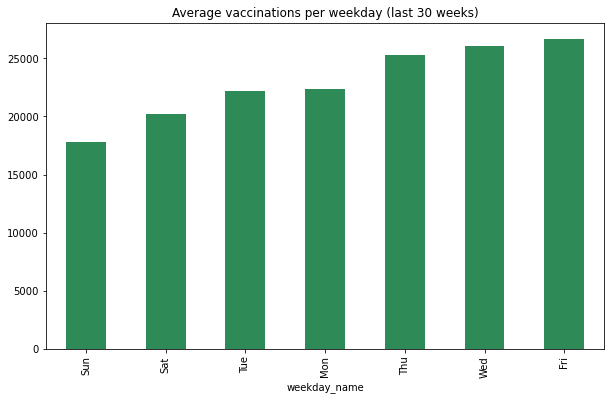

In [153]:
avg_vacs_per_weekday_last_x_weeks(30)

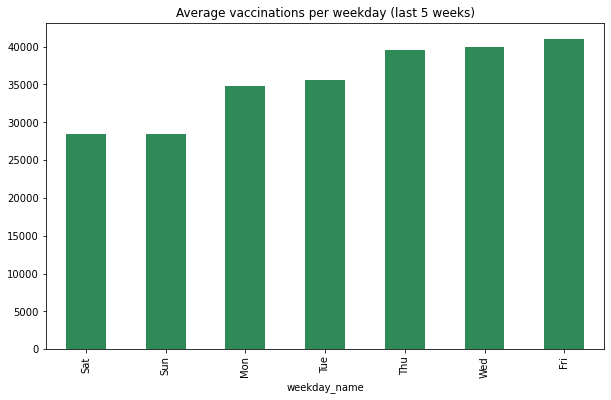

In [154]:
avg_vacs_per_weekday_last_x_weeks(5)

## Vaccinations per calendar week

<AxesSubplot:title={'center':'Total vaccinations per calendar week'}, xlabel='calendar_week'>

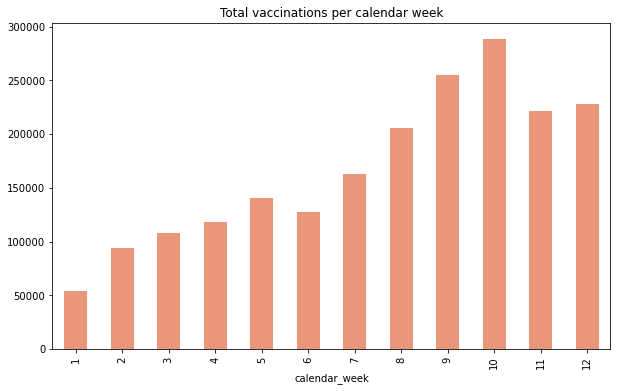

In [155]:
# tail(length - 5) removes 53 calendar week
df.tail(len(df.index) - 8).groupby(["calendar_week"])['vortag_dosen_dif'].sum().plot.bar(x='weekday_name', figsize=(10,6), color='darksalmon', title=f'Total vaccinations per calendar week')


<AxesSubplot:title={'center':'Average vaccinations per calendar week'}, xlabel='calendar_week'>

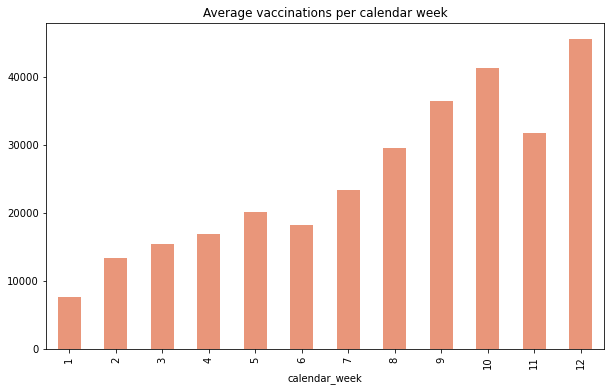

In [156]:
# tail(length - 5) removes 53 calendar week
df.tail(len(df.index) - 8).groupby(["calendar_week"])['vortag_dosen_dif'].mean().plot.bar(x='weekday_name', figsize=(10,6), color='darksalmon', title=f'Average vaccinations per calendar week')
